# Geolocating Aerial Photography

In [1]:
import pandas as pd
import numpy as np
import statistics
from scipy.spatial.transform import Rotation as R
import scipy.linalg
from scipy.interpolate import bisplrep, bisplev
from pyquaternion import Quaternion
import gdal
import os
from PIL import Image
import cv2
from itertools import combinations
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.image
from mpl_toolkits.mplot3d import Axes3D
import progressbar
from geopy import distance
import geopy
import time
import glob
import imutils

%matplotlib inline
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

import warnings
warnings.filterwarnings("ignore")

In [3]:
class TopoCompare():

    def prep_photos(self, images_path, dest_path, crop_left=0, crop_top=0, crop_right=0, crop_bottom=0):
        """
        Converts .tif files to .jpg files for ingestion into COLMAP.  May also crop images.

        Inputs:
        images_path: path to folder containing images to be prepped.
        dest_path: path to folder to where converted images will be saved.
        crop_left: pixels to crop on left side of photo.
        crop_top: pixels to crop off top of photo.
        crop_right: pixels to crop on right side of photo.
        crop_bottom: pixels to crop from bottom of photo.
        """
        for file in os.listdir(images_path):
            if (len(file.split('.')) > 1) and (file.split('.')[1] == 'tif'):
                file_path = os.path.join(images_path, file)
                image = Image.open(file_path)
                width, height = image.size
                image = image.crop((crop_left, crop_top, width-crop_right, height-crop_bottom))
                image.save(os.path.join(dest_path,file.split('.')[0]+"_cropped.jpg"))
            else:
                pass
        return None

    def ingest_images(self, path):
        """
        Ingests image center information from the images.txt file generated after pressing file>export model as text in COLMAP.

        inputs: 
        path: path to images.txt file created by exporting sparse model as text from COLMAP
        outputs:
        df: dataframe containing pertinent information from the images.txt file
        """
        #top 4 rows are header and every other row after that is not important to this 
        skiprows = [0,1,2,3]

        #counts the number of lines in the file.
        num_lines = 0
        with open(path, 'r') as f:
            for line in f:
                num_lines += 1

        skiprows.extend([i for i in range(5,num_lines,2)])

        df = pd.read_csv(path, header=None, skiprows=skiprows, delimiter=' ')
        df.columns = ['IMAGE_ID', 'QW', 'QX', 'QY', 'QZ', 'TX', 'TY', 'TZ', 'CAMERA_ID', "NAME"]
        return df
    
    
    def find_camera_centerpoints(self, df):
        """
        Takes the resulting dataframe from "ingest_images" and returns a dataframe with the explicit
        x,y,z centerpoints of the cameras.

        inputs:
        df: dataframe that resutls from properly executing ingest_image_centers.
        outputs:
        df_return: input df with X,Y,Z centerpoints appended
        """

        df_locs = pd.DataFrame([])

        for row in range(0,df.shape[0]):
            quaternion = Quaternion(w=df.iloc[row][1], x=df.iloc[row][2], y=df.iloc[row][3], z=df.iloc[row][4])
            rot = quaternion.rotation_matrix
            trans = np.array([df.iloc[row][5], df.iloc[row][6], df.iloc[row][7]])
            pos = pd.DataFrame(np.matmul(-rot.T,trans))
            df_locs = pd.concat([df_locs, pos.T])

        df_locs.index = range(0,df.shape[0])
        df_locs.columns = ['X', 'Y', 'Z']

        df_return = pd.concat([df, df_locs], axis = 1, sort= True)
        return df_return
    
    
    def ingest_points(self, path):
        """
        Ingests points information from the points3D.txt file generated after pressing file>export model as text in COLMAP.

        inputs: 
        path: path to points3D.txt file created by exporting sparse model as text from COLMAP
        outputs:
        df_points: dataframe containing pertinent information from the points3D.txt file
        """
        skiprows = [0,1,2]
        df_points = pd.read_csv(path, header=None, usecols=[0,1,2,3,7,8], skiprows=skiprows, delimiter=' ')
        df_points.columns = ['POINT3D_ID', 'X', 'Y', 'Z', 'ERROR','IMAGE_ID']
        df_points.index = range(df_points.shape[0])
        return df_points
    
    
    def reduce_points(self, df_points, df_camera_centerpoints):
        """
        Excludes points from the points3D dataframe that are outside the X and Y bounds of the df_camera_centerpoints
        X and Y range.  This increases the accuracy of the 3D representation and excludes datapoints that may be warped
        due to their position outside the boundaries of the image photomerge.

        inputs:
        df_points: the output of a correctly executed ingest_points function.
        df_camera_centerpoints: the output of a correctly executed find_camera_centerpoints function.
        outpus:
        df_points_reduced: df_points excluding points where X,Y is gt or lt maximum extent of X,Y in df_camera_centerpoints
        """
        df_points_reduced = df_points[(df_points['X'] < df_camera_centerpoints['X'].max())]
        df_points_reduced = df_points_reduced[(df_points['X'] > df_camera_centerpoints['X'].min())]
        df_points_reduced = df_points_reduced[(df_points['Y'] < df_camera_centerpoints['Y'].max())]
        df_points_reduced = df_points_reduced[(df_points['Y'] > df_camera_centerpoints['Y'].min())]
        return df_points_reduced


    def detect_and_describe(self, image, alg = "SIFT"):
        """
        Modified from https://www.pyimagesearch.com/2016/01/11/opencv-panorama-stitching/.
        SIFT algorithm reqiores opencv-python 3.4.2.17 and opencv-contrib-python 3.4.2.17 
        because later versions make the SIFT method proprietary.
        returns keypoints and feature vectors from one of several keypoint detection algorithms.
        
        inputs:
        image: cv2.image for which keypoints will be detected
        alg: string ["SIFT", "ORB", or "BRIKS"] determins which algorithm will be used
        
        outputs:
        kps: locations of keypoints
        features: feature vectors fo keypoints
        """
        # convert the image to grayscale
        #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if alg == "SIFT":
            descriptor = cv2.xfeatures2d.SIFT_create()
        elif alg == "ORB":
            descriptor = cv2.ORB_create()
        elif alg == "BRISK":
            descriptor = cv2.BRISK_create()
        (kps, features) = descriptor.detectAndCompute(image, None)
        kps = np.float32([kp.pt for kp in kps])
        true_kps = []
        true_features = []
        
        count = 0
        for kpsx, kpsy in kps:
            #if any of the surrounding pixels are zero (have a color of [84,1,68]), skip them
            if (image[int(round(kpsy,0)),int(round(kpsx,0))] != np.array([84,1,68])).all() or \
               (image[int(round(kpsy,0))+1,int(round(kpsx,0))] != np.array([84,1,68])).all() or \
               (image[int(round(kpsy,0)),int(round(kpsx,0))+1] != np.array([84,1,68])).all() or \
               (image[int(round(kpsy,0))-1,int(round(kpsx,0))] != np.array([84,1,68])).all() or \
               (image[int(round(kpsy,0)),int(round(kpsx,0))-1] != np.array([84,1,68])).all() or \
               (image[int(round(kpsy,0))-1,int(round(kpsx,0))-1] != np.array([84,1,68])).all() or \
               (image[int(round(kpsy,0))+1,int(round(kpsx,0))+1] != np.array([84,1,68])).all():
                true_kps.append([kpsx, kpsy])
                true_features.append(features[count])
            count+=1
        true_kps = np.float32(true_kps)
        true_features = np.array(true_features)
        return (true_kps, true_features)

    def match_keypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
        """
        Modified from https://www.pyimagesearch.com/2016/01/11/opencv-panorama-stitching/.
        returns the matching keypoints and homography matrix based on feature vectors returned from detect_and_describe.
        
        inputs:
        kpsA: list keypoints from image A
        kpsB: list keypoints from image B
        featuresA: features from image A
        featuresB: features from image B
        ratio: lowe's ratio test ratio
        reprojThresh: threshold number of keypoint matches for reprojection to occur
        
        outputs:
        matches: list of matching keypoints
        H: homography matrix
        status: status of homography matrix search
        """
        # compute the raw matches and initialize the list of actual matches
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
        matches = []

        # loop over the raw matches
        for m in rawMatches:
            # ensure the distance is within a certain ratio of each other (i.e. Lowe's ratio test)
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))

        # computing a homography requires at least 4 matches
        if len(matches) > 4:
            # construct the two sets of points
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])

            # compute the homography between the two sets of points
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)

            # return the matches along with the homograpy matrix and status of each matched point
            return (matches, H, status)

        # otherwise, no homograpy could be computed
        return None

    
    def procrustes(self, X, Y, scaling=True, reflection=False):
        """
        Modified from https://stackoverflow.com/questions/18925181/procrustes-analysis-with-numpy
        A port of MATLAB's `procrustes` function to Numpy.

        Procrustes analysis determines a linear transformation (translation,
        reflection, orthogonal rotation and scaling) of the points in Y to best
        conform them to the points in matrix X, using the sum of squared errors
        as the goodness of fit criterion.

        inputs:
        X: matrix of input coordinates
        Y: matrix of target coordinates.  Must have equal number of points (rows) to X, but may have 
        fewer dimensions than X
        scaling: if False, the scaling component of the transformation is forced to 1.
        reflection: if 'best' (default), the transformation solution may or may not include a reflection 
        component, depending on which fits the data best. setting reflection to True or False forces a 
        solution with reflection or no reflection respectively.

        outputs
        tform: a dict specifying the rotation, translation and scaling that maps X --> Y

        """

        n,m = X.shape
        ny,my = Y.shape
        muX = X.mean(0)
        muY = Y.mean(0)
        X0 = X - muX
        Y0 = Y - muY
        ssX = (X0**2.).sum()
        ssY = (Y0**2.).sum()

        # centred Frobenius norm
        normX = np.sqrt(ssX)
        normY = np.sqrt(ssY)
        # scale to equal (unit) norm
        X0 /= normX
        Y0 /= normY

        if my < m:
            Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

        # optimum rotation matrix of Y
        A = np.dot(X0.T, Y0)
        U,s,Vt = np.linalg.svd(A,full_matrices=False)
        V = Vt.T
        T = np.dot(V, U.T)

        if reflection is not 'best':
            # does the current solution use a reflection?
            have_reflection = np.linalg.det(T) < 0
            # if that's not what was specified, force another reflection
            if reflection != have_reflection:
                V[:,-1] *= -1
                s[-1] *= -1
                T = np.dot(V, U.T)

        traceTA = s.sum()

        if scaling:
            # optimum scaling of Y
            b = traceTA * normX / normY
            # standarised distance between X and b*Y*T + c
            d = 1 - traceTA**2
            # transformed coords
            Z = normX*traceTA*np.dot(Y0, T) + muX
        else:
            b = 1
            d = 1 + ssY/ssX - 2 * traceTA * normY / normX
            Z = normY*np.dot(Y0, T) + muX

        # transformation matrix
        if my < m:
            T = T[:my,:]
        c = muX - b*np.dot(muY, T)
        #transformation values 
        tform = {'rotation':T, 'scale':b, 'translation':c}

        return tform
    
    
    def match_2_images(self, kpsA, kpsB, featuresA, featuresB, num_matches, ratio, reprojThresh):
        """
        Returns the results for procrustes from the keypoints and features of two images.
        
        inputs:
        kpsA: list keypoint locations of image A
        kpsB: list keypoint locations of image B
        featuresA: list feature vectors describimg kpsA from imageA
        featuresB: list feature vectors describing kpsB from imageB
        num_matches: int number of to be considerded for tform calculation
        ratio: ratio for lowe's ratio test
        reprojThresh: threshold number of keypoint matches for reprojection to occur
        
        outputs:
        tform: a dict specifying the rotation, translation and scaling that maps X --> Y
        
        """
        matches, H, status = self.match_keypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)
        if len(matches) >= num_matches:
            matchesA = []
            matchesB = []
            for match in matches:
                matchesA.append(list(kpsA[match[1]]))
                matchesB.append(list(kpsB[match[0]]))
            matchesA = np.array(matchesA)
            matchesB = np.array(matchesB)
            tform = self.procrustes(matchesA, matchesB, True, False)
            return tform
        else:
            return None
        
        
    def map_photo_centerpoints(self, df_camera_centerpoints, num_x, num_y):
        """
        returns a pd.DataFrame with the relative positions of the images given in df_camera_centerpoints
        
        inputs:
        df_camera_centerpoints: pd.DataFrame, df_camera_centerpoints output form find_camera_centerpoints
        num_x: number of photos in the x direction.
        num_y: number of photos in the y direction.
        
        outputs:
        df_photo_array: pd.DataFrame with the relative positions of the images given in df_camera_centerpoints
        """
        
        df_photo_array = pd.DataFrame(np.array(df_camera_centerpoints.sort_values(["X", "Y"]).NAME).reshape(num_x,num_y)).T
        return df_photo_array
    
    
    def measure_scale(self, df_images, df_points_reduced, df_photo_array, scale, height_in, width_in):
        """
        Measures a lower bound for the scale in the images used for reconstruction.  Returns a value in terms 
        of meters per unit x and meters per unit y

        inputs:
        df_images: data frame produced by correctly specified call of ingest_images function
        df_points_reduced: data frame produced by correctly specified call of reduce_points function
        df_photo_array: dataframe produced by correctly specified call of map_photo_centerpoints function
        scale: scale of scanned image e.g. (1:20000 scale image would have scale = 20000)
        height_in: height of scanned image in inches.
        width_in: width of scanned image in inches.

        Outputs:
        x_scale_m: lower limit of meters per unit in direction x
        y_scale_m: lower limit of meters per unit in direction y

        """
        df_photo_array_x = pd.DataFrame(df_photo_array.iloc[:,1:df_photo_array.shape[1]-1])
        df_photo_array_y = df_photo_array.iloc[1:df_photo_array.shape[0]-1,:]

        image_id_dict_x = {}
        for row in df_photo_array_x.values:
            for NAME in row:
                image_id_dict_x[NAME] = (df_images[df_images['NAME']==NAME]['IMAGE_ID'].values[0])

        image_id_dict_y = {}
        for row in df_photo_array_y.values:
            for NAME in row:
                image_id_dict_y[NAME] = (df_images[df_images['NAME']==NAME]['IMAGE_ID'].values[0])

        x_diff = []
        for IMAGE_ID in image_id_dict_x.values():
            x_diff.append(df_points_reduced[df_points_reduced['IMAGE_ID']==IMAGE_ID].X.max()-df_points_reduced[df_points_reduced['IMAGE_ID']==IMAGE_ID].X.min())

        y_diff = []
        for IMAGE_ID in image_id_dict_y.values():
            y_diff.append(df_points_reduced[df_points_reduced['IMAGE_ID']==IMAGE_ID].Y.max()-df_points_reduced[df_points_reduced['IMAGE_ID']==IMAGE_ID].Y.min())
        
        #rescale to meters.
        photo_dims_y_mi = height_in * scale/(12*5280)
        photo_dims_x_mi = width_in * scale/(12*5280)
        photo_dims_y_km = photo_dims_y_mi*1.60934
        photo_dims_x_km = photo_dims_x_mi*1.60934

        x_scale_m = (photo_dims_x_km * 1000)/max(x_diff) #meters per x
        y_scale_m = (photo_dims_y_km * 1000)/max(y_diff) #meters per y

        return x_scale_m, y_scale_m
    
    
    def get_height_model(self, df_points_reduced, scale_m, x_scale_m, y_scale_m):
        """
        "Smears" out the point cloud that was constructed by COLMAP to fill an array that has a scale of scale_m
        on a side.  The larger the scale_m value the more points get averaged and the lower the resolution of the resulting
        array, but the array is also less sparse since fewer boxes have null values.
        
        inputs:
        df_points_reduced: pd.DataFrame the result of self.reduce_points
        scale_m: the size of the "boxes" in the resulting topographic model, in meters.
        x_scale_m: the current scale of x in meters (the result of self.measure_scale)
        y_scale_m: the current scale of y in meters (the result of self.measure_scale)
        
        output:
        heights: np.array of the topography at a granualrity as specified by scale_m
        """
        
        x_range = int((df_points_reduced.X.max() - df_points_reduced.X.min())/(scale_m/x_scale_m))
        y_range = int((df_points_reduced.Y.max() - df_points_reduced.Y.min())/(scale_m/y_scale_m))
        
        #progress bar
        bar = progressbar.ProgressBar(maxval=y_range, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
        bar.start()
        count = 0

        df_heights = pd.DataFrame([])
        for y in range(y_range):
            x_row = []
            for x in range(x_range):
                x_row.append(df_points_reduced[(df_points_reduced["X"] < df_points_reduced.X.min()+(x+1)*(scale_m/x_scale_m)) & 
                                       (df_points_reduced["X"] > df_points_reduced.X.min()+(x)*(scale_m/x_scale_m)) &
                                       (df_points_reduced["Y"] < df_points_reduced.Y.min()+(y+1)*(scale_m/y_scale_m)) & 
                                       (df_points_reduced["Y"] > df_points_reduced.Y.min()+(y)*(scale_m/y_scale_m))].Z.mean())

                
            df_heights = pd.concat([df_heights, pd.DataFrame(x_row).T], axis = 0)

            bar.update(y+1)
        heights = np.array(df_heights)
        return heights
    
    
    def rescale_usgs_topo(self, filepath, scale_m, scale_usgs):
        """
        Rescales a .img file of scale scale_usgs (in m) to a scale of scale_m.  scale_m in this function should be the
        same as scale_m in self.get_heights_model for the direct comparison method to work correctly.
        
        inputs:
        filepath: str filepath of .img topography data file supplied by usgs.
        scale_m: int scale of resulting array in m
        scale_usgs: int current scale of usgs data (in m, usually either 10 or 30)
        
        outputs:
        usgs_topo: np.array with rescaled usgs data.
        """
        
        geo = gdal.Open(filepath)
        drv = geo.GetDriver()
        north = geo.ReadAsArray()
        scale = int(scale_m/scale_usgs)
        scale_half = int(scale/2)

        df_usgs_topo = pd.DataFrame([])
        num_y = north.shape[0]

        bar = progressbar.ProgressBar(maxval=num_y, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
        bar.start()

        count = 0
        for y in range(scale_half,north.shape[1]-scale_half,scale):
            x_row = []
            for x in range(scale_half,north.shape[0]-scale_half,scale):
                x_row.append(pd.DataFrame(north).iloc[x-scale_half:x+scale_half,y-scale_half:y+scale_half].mean().mean())
            df_usgs_topo = pd.concat([df_usgs_topo, pd.DataFrame(x_row)], axis =1)

            bar.update(y+1)

        usgs_topo = np.array(df_usgs_topo)
        return usgs_topo
    
    
    def compare_as_images(self, mhnc, topo, mask, num_matches, step_divisor, ratio, reprojThresh, resize_multiplier = 2):
        """
        Performs a windowed search where topographies are treated as images.  If the number of matches is greater than
        or equal to num_matches then the x and y values are added to a list of possible matches to be searched pixel-wise.
        
        inputs:
        mhnc: np.ma.masked_array masked heights normed and centered
        topo: np.array usgs topographic data to be searched
        num_matches: int number of matches to add image search to pixelwise search 
        step_divisor: int number of steps to take per mhnc window size in x and y directions
        ratio: float (0.0-1.0) ratio for match_keypoints function  
        reprojThresh: int reprojThresh for match_keypoints function
        resize_multiplier: int how much to increase the size of the image to match keypoints
        
        outputs:
        possible_matches: list of lists with y, x coordinates of match points with corresponding tform outputs.


        """
        mhnc_height, mhnc_width = mhnc.shape
        topo_height, topo_width = topo.shape
        possible_matches = []

        #Progress bar
        bar = progressbar.ProgressBar(maxval=int((topo_height-mhnc_height)/(mhnc_height//step_divisor)+1), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
        bar.start()

        
        mhnc_filled = np.ma.filled(mhnc, 0)
        matplotlib.image.imsave('tmp_mhnc.png', mhnc_filled)
        imageA = cv2.imread('tmp_mhnc.png')
        imageA = cv2.resize(imageA, (imageA.shape[1]*resize_multiplier,imageA.shape[0]*resize_multiplier), interpolation = cv2.INTER_AREA)
        kpsA, featuresA = self.detect_and_describe(imageA, 'SIFT')
        counter = 0
        for y in range(0,topo_height-mhnc_height,mhnc_height//step_divisor):
            for x in range(0,topo_width-mhnc_width,mhnc_width//step_divisor):
                topo_tmp = topo[y:y+mhnc_height,x:x+mhnc_width]
                topo_tmp = np.ma.masked_array(topo_tmp, mask)
                topo_tmp = np.ma.filled(topo_tmp, 0)
                if (topo_tmp == np.zeros((mhnc_height,mhnc_width))).all():
                    pass
                else:
                    matplotlib.image.imsave('tmp_topo.png', topo_tmp)
                    imageB = cv2.imread('tmp_topo.png')
                    imageB = cv2.resize(imageB, (imageB.shape[1]*resize_multiplier,imageB.shape[0]*resize_multiplier), interpolation = cv2.INTER_AREA)
                    kpsB, featuresB = self.detect_and_describe(imageB, 'SIFT')
                    if len(kpsA) > 0 and len(kpsB) > 1: 
                        if self.match_keypoints(kpsA, kpsB, featuresA, featuresB, ratio=ratio, reprojThresh=reprojThresh) is not None:
                            matches, H, status = self.match_keypoints(kpsA, kpsB, featuresA, featuresB, ratio=ratio, reprojThresh=reprojThresh)
                            tform = self.match_2_images(kpsA, kpsB, featuresA, featuresB, num_matches, ratio, reprojThresh)
                            
                            if len(matches) >= num_matches:
                                possible_matches.append([y,x,tform])
            bar.update(counter)
            counter += 1
        
        os.remove("tmp_topo.png")
        os.remove("tmp_mhnc.png")
        return possible_matches
    
    def compare_pixelwise(self, mhnc, topo, mask, start_x, start_y, match_x, match_y, step_divisor):
        """
        Performs a pixelwise search in the area around a "possible_match." Sums the differences in Z value given the for
        all pixels in search window, adds result to df_diff and then moves one pixel to the right.  At right edge of window
        moves down one pixel.
        
        inputs:
        mhnc: np.ma.masked_array masked heights normed and centered
        topo: np.array usgs topographic data to be searched
        mask: np.ma.mask mask of mhnc
        start_x: int x coordinant of starting location in original topo reference frame 
        start_y: int y coordinate of starting location in original topo reference frame
        match_x: int x coordinate of starting location in rotated topo reference frame
        match_y: int x coordinate of starting location in rotated topo reference frame
        step_divisor: int number of steps to take per mhnc window size in x and y directions
        
        outputs:
        df_diff: pd.DataFrame of differences with cooresponding x and y locations in original topo reference frame 
        """
        
        mhnc_height, mhnc_width = mhnc.shape
        topo_height, topo_width = topo.shape

        #matplotlib.image.imsave('mhnc.png', mhnc)
        #mhnc_image = matplotlib.image.imread('mhnc.png')

        diff = []
        for y_min in range(max(start_y-mhnc_height//step_divisor,0),min(start_y+mhnc_height//step_divisor, topo_height-mhnc_height//step_divisor)):
            y_max = y_min + mhnc_height
            for x_min in range(max(start_x-mhnc_width//step_divisor,0),min(start_x+mhnc_width//step_divisor, topo_width-mhnc_width//step_divisor)):
                x_max = x_min + mhnc_width
                new_topo = topo[y_min:y_max, x_min:x_max]
                new_topo_normed = (new_topo - np.min(new_topo))/np.ptp(new_topo)
                if mask.shape == new_topo_normed.shape:
                    mntn = np.ma.masked_array(new_topo_normed, mask)
                    difference = abs(mntn - mhnc).sum().sum()
                    diff.append([x_min, y_min, difference])
                else:
                    diff.append([x_min, y_min, 9999])

        df_diff = pd.DataFrame.from_records(diff)
        return df_diff
    
    def rotate(self, origin, point, angle):
        """
        This function is modified from: 
        https://stackoverflow.com/questions/34372480/rotate-point-about-another-point-in-degrees-python
        Rotate a point counterclockwise by a given angle around a given origin.

        origin: 2-tuple of ints (x,y) the point around which the figure is to be rotated.
        point: 2-tuple of ints (x,y) the point to rotate.
        angle: float or int the angle (in degrees) to rotate the point.
        """
        angle = math.radians(angle)
        ox, oy = origin
        px, py = point

        qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
        qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
        ans = [qx, qy]
        return ans
    
    def topo_compare(self, images_loc, points_loc, state, num_pic_x, num_pic_y, scale, height_in, width_in, meters_per_pixel=180, center_pixels = 15, step_divisor=4, num_matches=15, ratio=0.8, reprojThresh=4, demo=False):
        """
        This is the main function of the "Geolocating Aerial Photography" project.  It identifies
        the "best fit" location matching topography from COLMAPS.
        
        inputs:
        images_loc: str path to images.txt file generated by COLMAP
        points_loc: str path to points3D.txt file generated by COLMAP 
        state: str only accepted string is "California" at the moment
        num_pic_x: int number of images in the x direction
        num_pic_y: int number of images in the y direction
        scale: int scale of image (1:20000 scale would be 20000)
        height_in: int or float height of input images in inches
        width_in: int or float width of input images in inches
        meters_per_pixel: int (default 180) meters per pixel in reconstructed topography and in usgs topography
        center_pixels: int (default 15) number of pixels to crop form the edges of the reconstruction to reduce np.nans.
        step_divisor: int (default 4) number of steps to take per mhnc window size in x and y directions
        num_matches: (default 8) int number of matches to add image search to pixelwise search 
        ratio: (default 0.8) lowe's ratio test ratio
        reprojThresh: (default 4) threshold number of keypoint matches for reprojection to occur
        demo bool if True only runs the search over topo file imgn35w120_1.npy - if False runs search over whole of specified state.

        outputs:
        mhnc: np.ma.masked_array the normalized topography of the photographed area fed into COLAMP
        df_diff: pd.DataFrame dataframe containing all the pixelwise differences and their x and y coordinates
        df_min: pd.DataFrame dataframe containing the x and y coordinates of the location with the lowest pixelwise difference
        """
        
        #Load state topography from USGS
        if demo == True:
            topo = np.load(os.path.join('..','geo_data','california','imgn35w120_1.npy'))
        elif demo == False and state.lower() == "california":
            topo = np.zeros(((42-32)*601,(125-113)*601))
            for npy in glob.glob('../geo_data/california/*.npy'):
                tmp = np.load(npy)
                n = int(npy.split('imgn')[-1][0:2])
                w = int(npy.split('w')[-1][0:3])
                topo[601*-(n-42):601*-(n-43),601*(-(w-125)):601*(-(w-126))] = tmp
            topo[topo < -86] = 0

        #Ingest data from COLMAP
        print('Constructing Heights Model')
        df_images = self.ingest_images(images_loc)
        df_points = self.ingest_points(points_loc)
        df_camera_centerpoints = self.find_camera_centerpoints(df_images)
        df_points_reduced = self.reduce_points(df_points, df_camera_centerpoints)
        df_photo_array = self.map_photo_centerpoints(df_camera_centerpoints, num_pic_x, num_pic_y)

        #Measure scale and multiply by correction factor
        x_scale_m, y_scale_m = self.measure_scale(df_images, df_points_reduced, df_photo_array, scale, height_in, width_in)
        x_scale_m = 1.40*x_scale_m #rescale determined emperically
        y_scale_m = 1.40*y_scale_m #rescale determined emperically
        heights = self.get_height_model(df_points_reduced, meters_per_pixel, x_scale_m, y_scale_m)
        heights = -heights #invert z axis per COLMAP output

        #Remove high and low topography as they tend to be anomalies from COLMAP 
        heights[heights >= np.nanpercentile(heights, 99)] = np.nan
        heights[heights <= np.nanpercentile(heights, 1)] = np.nan

        #Mask array where COLMAP did not make a reconstruction or at 1st, 99th percentile
        mask = np.where(np.isnan(heights), 1, 0)
        masked_heights = np.ma.masked_array(heights, mask)
        masked_heights_norm = (masked_heights - np.min(masked_heights))/np.ptp(masked_heights) #norm 0-1
        mhnc = masked_heights_norm[center_pixels:-center_pixels,center_pixels:-center_pixels]
        mask_centered = mhnc.mask
        mhnc_filled = np.ma.filled(mhnc, 0.5)
        
        #Image Search
        print('Image Search')
        possible_matches = self.compare_as_images(mhnc, topo, mask_centered, num_matches, step_divisor, ratio, reprojThresh)
        print(len(possible_matches))
        
        #Progress bar
        print('Pixelwise Search')
        count = 0
        bar = progressbar.ProgressBar(maxval=len(possible_matches), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
        bar.start()
        
        df_diff = pd.DataFrame([])
        
        #loop through possible matches, if translation is too great then pass
        for match in possible_matches:
            count+=1
            bar.update(count)
            if (match[2]['translation'][0] > 100) or (match[2]['translation'][1] > 100) and (match[2]['scale'] >= 2) and (match[2]['scale'] <= 0.5):
                pass
            else:
                
                #assign rotation angle from tform rotation matrix
                if match[2] and match[2]['rotation'][0,1] <= 1 and match[2]['rotation'][0,1] >= -1 and match[2]['rotation'][0,0] <= 1 and match[2]['rotation'][0,0] >= -1:
                    angle1 = -math.degrees(math.asin(match[2]['rotation'][0,1]))
                    angle2 = math.degrees(math.acos(match[2]['rotation'][0,0]))
                    if round(angle1,2) == round(angle2,2):
                        angle = angle1
                    else:
                        angle = angle1 + 180
                        
                    #Perform pixelwise search of rotated area
                    if not math.isnan(angle):
                        topo_rotated = imutils.rotate_bound(topo, angle)
                        new_coords = self.rotate((topo.shape[0]//2,topo.shape[1]//2), (match[0],match[1]), angle)
                        new_coords[0] = int(max(round(new_coords[0] + (topo_rotated.shape[0] - topo.shape[0])//2,0),0))
                        new_coords[1] = int(max(round(new_coords[1] + (topo_rotated.shape[1] - topo.shape[1])//2,0),0))
                        diff = self.compare_pixelwise(mhnc, topo_rotated, mask_centered, new_coords[1], new_coords[0], match[1], match[0], step_divisor)
                        diff['3'] = angle
                        df_diff = pd.concat([df_diff, diff])
                        
                else:
                    pass
        
        #reindex df_diff and find minimum difference
        df_diff.index = range(df_diff.shape[0])
        df_min = df_diff[df_diff[2] == df_diff[2].min()]
        
        #Find lat and long of minimum coordinates
        x_min = df_min.iloc[0][0]
        y_min = df_min.iloc[0][1]

        x_min_local = x_min-(601*(x_min//601))
        y_min_local = y_min-(601*(y_min//601))

        bearing = 180 - math.degrees(math.atan((meters_per_pixel*x_min_local)/(meters_per_pixel*y_min_local)))
        if demo == True:
            start = geopy.Point(35,-120)
        elif demo == False and state.lower() == "california":
            start = geopy.Point(42-(y_min//601),-125+(x_min//601))
        d = geopy.distance.distance(meters = math.sqrt(((meters_per_pixel*x_min_local)**2 + (meters_per_pixel*y_min_local)**2)))
        destination = d.destination(point=start, bearing=bearing)
        df_min['best_fit_lat'] = destination.latitude
        df_min['best_fit_long'] = destination.longitude
        
        df_min.columns = ['x_pixels', 'y_pixels', 'min_value', 'rotation', 'best_fit_lat', 'best_fit_long']
        
        print("Complete")
        
        return mhnc, df_diff, df_min

## Prepare Photos

In [18]:
TC = TopoCompare()
TC.prep_photos(images_path = '../../images/btm-1954/raw/area_8/', \
            dest_path = '../../images/btm-1954/cropped/area_8', \
            crop_left = 0, \
            crop_top = 0, \
            crop_right = 0, \
            crop_bottom = 0)

## Demo

In [15]:
TC = TopoCompare()
mhnc, df_diff, df_min = TC.topo_compare(images_loc = '../colmap_reconstruction/btm-1954_7/images.txt', \
                                      points_loc = '../colmap_reconstruction/btm-1954_7/points3D.txt', \
                                      state = 'California', \
                                      num_pic_x = 6, \
                                      num_pic_y = 12, \
                                      scale = 20000, \
                                      height_in = 9, \
                                      width_in = 9, \
                                      num_matches = 15, \
                                      demo=True)

Constructing Heights Model


Image Search


356
Pixelwise Search


Complete


## Results

In [16]:
df_min

,x_pixels,y_pixels,min_value,rotation,best_fit_lat,best_fit_long
327029,141,208,707.673926,3.179388,34.662196,-119.723114


## Plotting

Text(0.5, 1.0, 'USGS Topography')

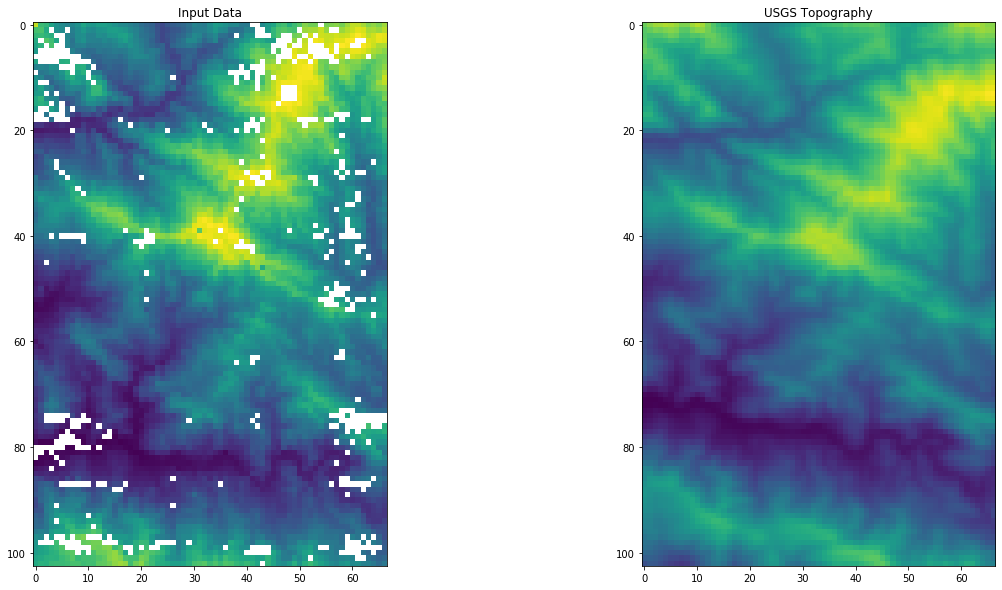

In [17]:
topo = np.load(os.path.join('..','..','geo_data','states','california.npy'))
topo = np.load(os.path.join('..','geo_data','california','imgn35w120_1.npy'))
topo_rotated = imutils.rotate_bound(topo, df_min.iloc[0]['rotation'])

width, height = mhnc.shape
x_min = int(df_min.iloc[0][0])
y_min = int(df_min.iloc[0][1])

plt.figure(1, figsize=(20,10))
plt.subplot(121)
plt.title('Input Data')
plt.imshow(mhnc)
plt.subplot(122)
plt.imshow(topo_rotated[y_min:y_min+width,x_min:x_min+height])
plt.title("USGS Topography")

## Search All of California

In [13]:
TC = TopoCompare()
mhnc, df_diff, df_min = TC.topo_compare(images_loc = '../colmap_reconstruction/btm-1954_7/images.txt', \
                                      points_loc = '../colmap_reconstruction/btm-1954_7/points3D.txt', \
                                      state = 'California', \
                                      num_pic_x = 6, \
                                      num_pic_y = 12, \
                                      scale = 20000,\
                                      height_in = 9,\
                                      width_in = 9,\
                                      num_matches = 20, \
                                      demo=False)

Constructing Heights Model


Image Search


18787
Pixelwise Search


Complete


## Results

In [14]:
df_min

,x_pixels,y_pixels,min_value,rotation,best_fit_lat,best_fit_long
23346191,3141.0,4432.0,688.985901,0.510108,34.638676,-118.845936


## Plotting

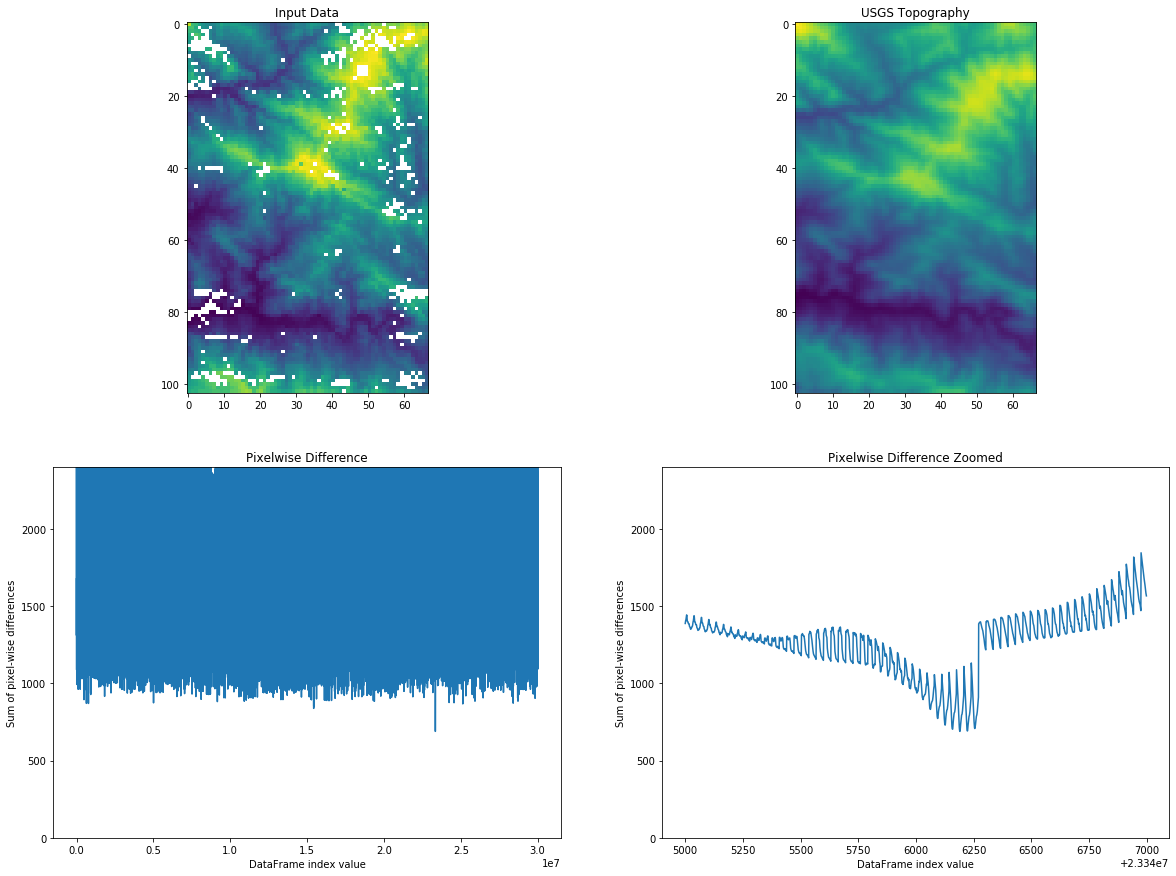

In [40]:
topo = np.load(os.path.join('..','..','geo_data','states','california.npy'))
topo_rotated = imutils.rotate_bound(topo, df_min.iloc[0]['rotation'])

width, height = mhnc.shape
x_min = int(df_min.iloc[0][0])
y_min = int(df_min.iloc[0][1])

plt.figure(1, figsize=(20,15))
plt.subplot(221)
plt.title('Input Data')
plt.imshow(mhnc)
plt.subplot(222)
plt.imshow(topo_rotated[y_min:y_min+width,x_min:x_min+height])
plt.title("USGS Topography")
plt.subplot(223)
plt.plot(df_diff[2])
plt.ylim(0,2400)
plt.xlabel('DataFrame index value')
plt.ylabel('Sum of pixel-wise differences')
plt.title("Pixelwise Difference")
plt.subplot(224)
plt.plot(df_diff[2][23345000:23347000])
plt.ylim(0,2400)
plt.xlabel('DataFrame index value')
plt.ylabel('Sum of pixel-wise differences')
plt.title("Pixelwise Difference Zoomed")
plt.show()

In [86]:
x_min = df_min.iloc[0][0]
y_min = df_min.iloc[0][1]

x_min_local = x_min-(601*(x_min//601))
y_min_local = y_min-(601*(y_min//601))

bearing = 180 - math.degrees(math.atan((180*x_min_local)/(180*y_min_local)))
start = geopy.Point(42-(y_min//601),-125+(x_min//601))
d = geopy.distance.distance(meters = math.sqrt(((180*x_min_local)**2 + (180*y_min_local)**2)))
destination = d.destination(point=start, bearing=bearing)
df_min['best_fit_lat'] = destination.latitude
df_min['best_fit_long'] = destination.longitude

In [87]:
df_min

,x_pixels,y_pixels,min_value,rotation,best_fit_lat,best_fit_long,4,5
23346191,3141.0,4432.0,688.985901,0.510108,34.634635,-119.733021,34.638676,-118.845936
